# Neural citation network for local citation recommendation

In [1]:
import torch
from torchtext.data import BucketIterator
from ncn.evaluation import Evaluator
from ncn.data import get_datasets
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

In [2]:
path_to_weights = "/home/timo/Downloads/best_model_bn_TDNN/NCN_7_17_10.pt"
path_to_data = "/home/timo/DataSets/KD_arxiv_CS/arxiv_data.csv"

In [3]:
data = get_datasets(path_to_data)

INFO:neural_citation.data:Getting fields...
INFO:neural_citation.data:Loading dataset...
INFO:neural_citation.data:Building vocab...


In [4]:
def display_dict(d):
    """Display a dict nice and pretty."""
    for key, value in d.items():
        print(f"Citation rank {key}|\t {value}")

In [5]:
def display_attention(title, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap="plasma")
   
    ax.tick_params(labelsize=15)
    xlabels = ["Context TDNN 1 (f=4)", "Context TDNN 2 (f=4)", "Context TDNN 3 (f=5)",
              "Citing TDNN 1 (f=1)", "Citing TDNN 2 (f=2)",
              "Cited TDNN 1 (f=1)", "Cited TDNN 2 (f=2)"
              ]
    ax.set_xticklabels([''] + xlabels, 
                       rotation=90)
    # have tokenized title here
    ax.set_yticklabels([''] + title)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.colorbar(cax)

## Data: Basic statistics
1. Removed 8260 triplets of paper data due to empty/missing files.  
2. Removed 1 data sample throwing regex error.  
3. Removed 161670 context samples where information was missing/could not be parsed from files.   
* This leaves __502353 context - citation pairs__ with full information.
* __Context vocabulary__ size after processing: __72046__.  
* __Title vocabulary__ size after processing: __43208__.  
* Number of __citing authors__: __28200__.  
* Number of __cited authors__: __169236__. 

![Context and title length distributions](assets/title_context_distribution.jpg)

## Data preprocessing with torchtext Fields  
* __Tokenize and preprocess__ data strings.  
* __Numericalize__ data.  
* Containg __vocabularies__ built on the dataset.  
* Provide __batch processing__ of samples.  

In [59]:
context = "Neural networks are really cool, especially if they are convolutional."
authors = "Yoshua Bengio, Bruce Lee"

### Tokenization and Preprocessing
* Tokenization
* Stopword removal
* Lowercasing

In [60]:
tokenized = data.cntxt.tokenize(context)

In [61]:
tokenized

['Neural',
 'network',
 'be',
 'really',
 'cool',
 'especially',
 'if',
 'they',
 'be',
 'convolutional']

### Numericalization
* Matching words to vocabulary indices

In [62]:
data.cntxt.numericalize([tokenized])

tensor([[   0,    3,    0,    0, 4637,  775,    0,    0,    0,  413]])

### Batch processing
* Pad batches on the fly

In [63]:
examples = [example.context for example in data.train.examples[:30]]

In [64]:
examples[4]

['poon',
 'aim',
 'design',
 'uav',
 'noiseless',
 'vibration',
 'free',
 'use',
 'ionic',
 'propulsion',
 'uav',
 'inoic',
 'flyer',
 'fig']

In [65]:
tensorized = data.cntxt.numericalize(data.cntxt.pad(examples))

In [66]:
print(f"Batch data type: {tensorized.type()}")
print(f"Batch shape: {tensorized.shape}")
print(tensorized[:2, :])

Batch data type: torch.LongTensor
Batch shape: torch.Size([30, 32])
tensor([[ 1182,  2188,  1576,   478,   352,   119,    10,   197,   409, 17724,
             0,  6217,    26,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1],
        [  868,    13,   232,   730,    53,   343,   128,    12,   146,    32,
           280,   105,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1]])


## Bucketting: What it is and why do we need it?
* Drastically reduces training time.  
* Ensures all data in a batch is sorted according to certain key (title length in our case).  

In [67]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits((data.train, data.valid, data.test), 
                                                                          batch_size = 32,
                                                                          sort_within_batch = True,
                                                                          sort_key = lambda x : len(x.title_cited))

In [68]:
batch = next(iter(train_iterator))

In [69]:
batch.title_cited.permute(1,0)[:5]

tensor([[   2,  558,  255,  725, 1364,    6,  370,  343,   59,   25,    3],
        [   2,   23,  885,   67,   96,  217,  602,    9,   16,    7,    3],
        [   2, 1720,  292, 1285,  299,  168,    9,   20,  356,    4,    3],
        [   2,   17,  416, 1197,   19,  241,   87,    5,    5,   14,    3],
        [   2,  516,  548,  115,  851,   67,   63,  481, 2900,  530,    3]])

## Demo

In [70]:
evaluator = Evaluator(path_to_weights, data, evaluate=False, show_attention=True)

INFO:neural_citation.evaluation:INITIALIZING NEURAL CITATION NETWORK WITH AUTHORS = True
Running on: cpu
Number of model parameters: 23,533,236
Encoders: # Filters = 128, Context filter length = [4, 4, 5],  Context filter length = [1, 2]
Embeddings: Dimension = 128, Pad index = 1, Context vocab = 30002, Author vocab = 30002, Title vocab = 30004
Decoder: # GRU cells = 2, Hidden size = 128
Parameters: Dropout = 0.2, Show attention = True
-------------------------------------------------
INFO:neural_citation.evaluation:Creating corpus in eval=False mode.
INFO:neural_citation.evaluation:Number of samples in BM25 corpus: 1054941


In [71]:
recomms, a = evaluator.recommend(context, authors)

In [72]:
display_dict(recomms)

Citation rank 0|	 Environmental sound classification with convolutional neural   networks
Citation rank 1|	 Fully convolutional networks for semantic segmentation
Citation rank 2|	 Return of the devil   in the details: Delving deep into convolutional nets
Citation rank 3|	 Learning spatiotemporal features with 3d convolutional networks
Citation rank 4|	 Compression artifacts reduction   by a deep convolutional network


## But what about attention?

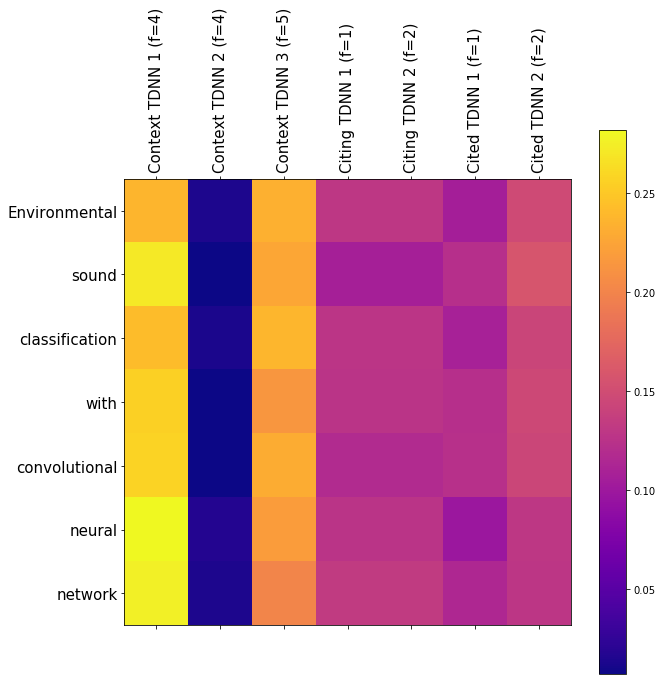

In [58]:
rec = 0
seq = data.cntxt.tokenize(recomms[rec])
display_attention(seq, a[1:len(seq)+1, rec, :])

## Documentation
![Context and title length distributions](assets/Documentation.png)